In [1]:
%load_ext autoreload
%autoreload 2

import builtins  # Not needed unless saving for github
builtins.use_bokeh_screenshot = True  # Not needed unless saving for github

from kaggle_speech_recog import *

from bokeh.io import output_notebook
output_notebook()

/usr/local/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading BokehJS ...

# Get feature matrix

In [ ]:
X_vector_len = 16000
test = SpeechList.get_test('test/audio')
X_test = test.get_spectrogram_feature_ndarray(vector_len=X_vector_len, spec_v='3', take_log=False)

/usr/local/anaconda3/lib/python3.6/site-packages/librosa/filters.py:261: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


# Predict

In [6]:
path2log = 'logs/NoveltyDetectionSpectrogramMultiLSTMRandomInputModify_graph_01_run_01.log'

In [7]:
log = pickle.load(open(path2log, 'rb'))
if hasattr(log.t_cnfg, 'ensemble_logs'):
    X_test = gather_logits(X_test, log_dir='logs', logs=log.t_cnfg.ensemble_logs)
GraphClass = globals()[log.graph_name]  # Pick up graph class used to train model
graph = GraphClass(log.g_cnfg)  # Load the same graph configuration
Y_test = graph.predict(X_test, ckp_dir=log.ckp_dir, batch_size=log.t_cnfg.batch_size)  # Use best model in checkpoint directory
test.add_predicted_label(Y_test, le=log.t_cnfg.le)
test.save_submission_csv(dir_='submissions', name=log.joined_name+'.csv')

None, test/audio/clip_4b8b01d0f.wav, sample rate 16000, data length 16000
prediction: unknown


/usr/local/anaconda3/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


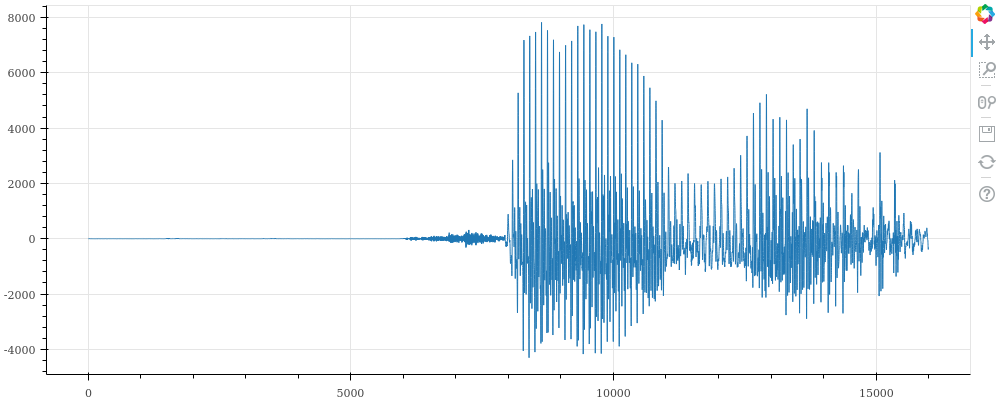

In [5]:
test[0].hear_and_see()  # 51511, 120099, 1234, 98765, 119965

# Novelty detection w/ custom classifier (hasn't improved score)

In [ ]:
path2log = 'logs/NoveltyDetectionSpectrogramMultiLSTMRandomInputModify_graph_01_run_01.log'

In [ ]:
log = pickle.load(open(path2log, 'rb'))
GraphClass = globals()[log.graph_name]  # Pick up graph class used to train model
graph = GraphClass(log.g_cnfg)  # Load the same graph configuration
sigmoid_test = graph.get_sigmoid(X_test, ckp_dir=log.ckp_dir, batch_size=log.t_cnfg.batch_size)  # Use best model in checkpoint directory
test.add_novelty_det_sigmoid(sigmoid_test)
test.save_submission_csv(dir_='submissions', name=log.joined_name+'.csv', 
                         use_novelty_det=True, novelty_det_sigmoid_threshold=0.01)

In [ ]:
in_class_labels = ['yes', 'no' , 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
filtered = test.get_list_of_predicted_label(in_class_labels).get_list_sigmoid_bw(low=0, high=0.01)
print(len(filtered))
filtered[0].hear_and_see()

# Novelty detection w/ OneClassSVM and IsolationTree (hasn't improved score)

In [ ]:
one_class_labels = ['yes', 'no' , 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_background_noise_']
#one_class_labels = train.get_labels()

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

train = SpeechList.get_train('train/audio')
one_class_svm = {}
for label in one_class_labels:
    speech_list = train.get_list_of_label([label])
    
    if label == '_background_noise_':
        speech_list.split_noise(X_vector_len)
        speech_list.fabricate_noise(1600, X_vector_len)
    
    X = speech_list.get_spectrogram_feature_ndarray(vector_len=X_vector_len, spec_v='3', take_log=False)
    Y = graph.predict(X, ckp_dir=log.ckp_dir, batch_size=log.t_cnfg.batch_size, annotate=False)
    one_class_svm[label] = IsolationForest(max_samples=len(speech_list), contamination=0.005).fit(Y)

In [ ]:
test.add_svm_predictions(Y_test, one_class_svm)
test.save_submission_csv(dir_='submissions', name=log.joined_name+'.csv', use_svm=True, keep_noise=True)